# sparsecluster demo

`sparsecluster` is a wrapper around `pynndescent` for efficient construction of nearest-neighbor graphs and `gbbs` for graph-based hierarchical clustering. the basic idea is to use an approximate distance matrix as input for linkage, in order to allow for clustering of large (and sparse) datasets

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import sparsecluster
import fastcluster
%matplotlib inline
from matplotlib import pyplot as plt
import scipy.cluster.hierarchy
import sklearn.cluster
import scipy.cluster
import sklearn.datasets
import pandas as pd
import time
import seaborn as sns

## simple demo example

for initial demo, use a random matrix for 10 samples and 5 features

In [2]:
np.random.seed(0)
X=np.random.rand(10,5)

as baseline, we construct a full distance matrix using `scipy.spatial.distance.pdist` and an exact linkage using `fastcluster`

In [3]:
metric='euclidean'
d0 = scipy.spatial.distance.pdist(X, metric=metric)
Z0s = fastcluster.linkage(d0, metric=metric, method='single')

now we use `sparsecluster` to construct distances and linkages for either 10 neighbors (i.e., the full matrix) or 5 neighbors (an approximation). during nearest-neighbor descent, we can store additional distances for `n_backup` non-nearest neighbors. 

In [4]:
Z1s,d1 = sparsecluster.linkage(X, metric=metric, method='single', n_neighbors=10, return_distance=True)
Z2s,d2 = sparsecluster.linkage(X, metric=metric, method='single', n_neighbors=5, n_backup=0, return_distance=True)

Text(0.5, 1.0, '5 nearest neighbors')

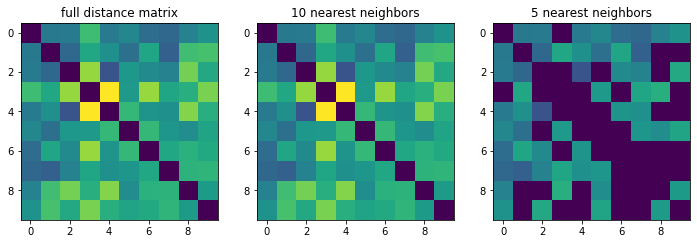

In [5]:
fig,axs=plt.subplots(1,3,figsize=(12,4))
axs[0].imshow(scipy.spatial.distance.squareform(d0), cmap=plt.cm.viridis, vmin=0, vmax=d0.max())
axs[0].set_title('full distance matrix')
axs[1].imshow(d1.todense(), cmap=plt.cm.viridis, vmin=0, vmax=d0.max())
axs[1].set_title('10 nearest neighbors')
axs[2].imshow(d2.todense(), cmap=plt.cm.viridis, vmin=0, vmax=d0.max())
axs[2].set_title('5 nearest neighbors')

even though the sparse approximation is missing entries for larger distances, the resulting dendrograms (using single linkage) are equivalent, possibly up to a re-ordering

Text(0.5, 1.0, '5 neighbors')

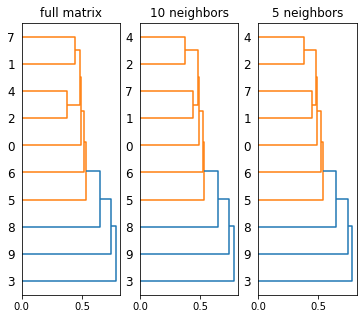

In [7]:
fig,axs=plt.subplots(1,3,figsize=(6,5),sharex=True)
L0=scipy.cluster.hierarchy.dendrogram(Z0s,ax=axs[0],orientation='right')
L1=scipy.cluster.hierarchy.dendrogram(Z1s,ax=axs[1],orientation='right')
L2=scipy.cluster.hierarchy.dendrogram(Z2s,ax=axs[2],orientation='right')
axs[0].set_title('full matrix')
axs[1].set_title('10 neighbors')
axs[2].set_title('5 neighbors')

try the same thing with complete or average linkage (but skipping the re-calculation of the distance matrices): 5 nearest neighbors is not always enough

In [8]:
Z0c = fastcluster.linkage(d0, metric=metric, method='complete')
Z1c = sparsecluster.linkage(X, dist=d1, metric=metric, method='complete', n_neighbors=10)
Z2c = sparsecluster.linkage(X, dist=d2, metric=metric, method='complete', n_neighbors=5)

Z0a = fastcluster.linkage(d0, metric=metric, method='average')
Z1a = sparsecluster.linkage(X, dist=d1, metric=metric, method='average', n_neighbors=10)
Z2a = sparsecluster.linkage(X, dist=d2, metric=metric, method='average', n_neighbors=5)

Text(0, 0.5, 'average linkage')

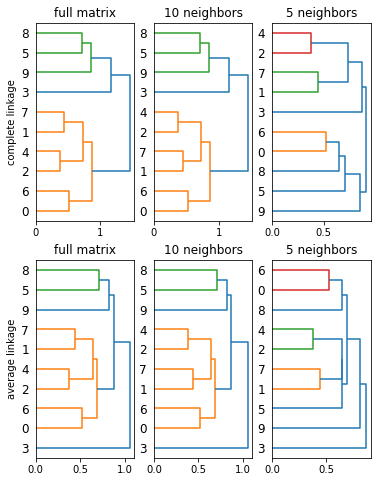

In [9]:
fig,axs=plt.subplots(2,3,figsize=(6,8))

L0=scipy.cluster.hierarchy.dendrogram(Z0c,ax=axs[0,0],orientation='right')
L1=scipy.cluster.hierarchy.dendrogram(Z1c,ax=axs[0,1],orientation='right')
L2=scipy.cluster.hierarchy.dendrogram(Z2c,ax=axs[0,2],orientation='right')

L0=scipy.cluster.hierarchy.dendrogram(Z0a,ax=axs[1,0],orientation='right')
L1=scipy.cluster.hierarchy.dendrogram(Z1a,ax=axs[1,1],orientation='right')
L2=scipy.cluster.hierarchy.dendrogram(Z2a,ax=axs[1,2],orientation='right')

axs[0,0].set_title('full matrix')
axs[0,1].set_title('10 neighbors')
axs[0,2].set_title('5 neighbors')

axs[1,0].set_title('full matrix')
axs[1,1].set_title('10 neighbors')
axs[1,2].set_title('5 neighbors')

axs[0,0].set_ylabel("complete linkage")
axs[1,0].set_ylabel("average linkage")

## how many neighbors are enough?

use the `digits` dataset to compare the `sparsecluster` linkages to the `fastcluster` linkages by means of "cophenetic distances" (i.e., distances along the tree)

In [10]:
digits = sklearn.datasets.load_digits()
X, y = digits.data, digits.target
n_samples, n_features = X.shape

In [12]:
nc=10

fastcluster_linkage = {}
for method in ("single", "complete", "average"):
    fastcluster_linkage[method] = fastcluster.linkage(X, method=method, metric='euclidean')
    
sparsecluster_linkage = {}
for nfrac in [.01, .02, .1, .2]:
    for bfrac in [0,1,2,5]:
        nn = int(nfrac*X.shape[0])
        Zs, ds = sparsecluster.linkage(X, metric='euclidean', method='single', 
                                       n_neighbors=nn, n_backup=bfrac*nn, n_jobs=1, return_distance=True)
            
        Zc = sparsecluster.linkage(X, dist=ds, metric='euclidean', method='complete')           
        Za = sparsecluster.linkage(X, dist=ds, metric='euclidean', method='average')           
        
        sparsecluster_linkage[('single',nfrac, bfrac)] = Zs
        sparsecluster_linkage[('complete',nfrac, bfrac)] = Zc
        sparsecluster_linkage[('average',nfrac, bfrac)] = Za

SystemError: CPUDispatcher(<function nn_descent at 0x151501589550>) returned a result with an error set

In [15]:
#cc=dict((k,scipy.statslen(fastcluster_linkage),len(sparsecluster_linkage)
d1=scipy.cluster.hierarchy.cophenet(fastcluster_linkage['single'])
d2=scipy.cluster.hierarchy.cophenet(sparsecluster_linkage[('single',.02,2)])

In [18]:
cc=dict((k,scipy.stats.pearsonr(scipy.cluster.hierarchy.cophenet(fastcluster_linkage[k[0]]),
                                scipy.cluster.hierarchy.cophenet(sparsecluster_linkage[k]))[0]) 
        for k in sparsecluster_linkage.keys())

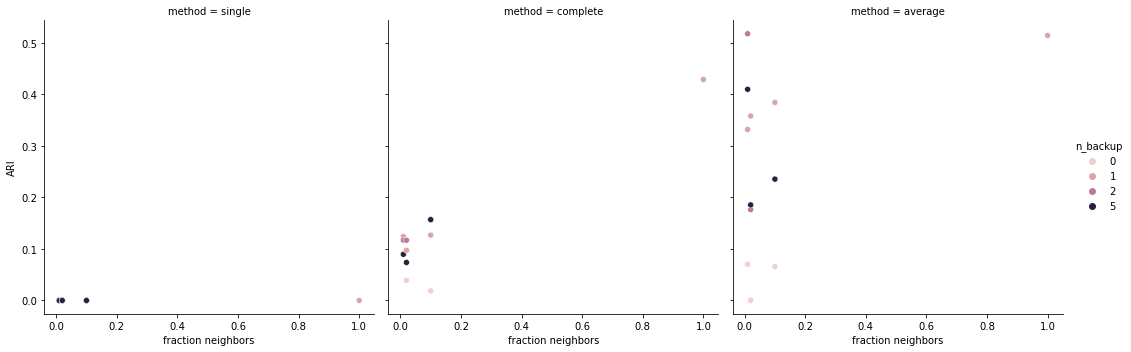

In [22]:
sns.relplot(data=pd.Series(ARI).reset_index().rename({'level_0': 'fraction neighbors',
                                                      'level_1': 'n_backup',
                                                      'level_2': 'method',
                                                     0: 'ARI'},axis=1),
            x='fraction neighbors',y='ARI',hue='n_backup',col='method')

## benchmarking time and memory usage

use the `20newsgroups_vectorized` sparse dataset for benchmarking

In [9]:
data,labels = sklearn.datasets.fetch_20newsgroups_vectorized(subset='train',
                                                             data_home='..',
                                                             return_X_y=True)

In [10]:
data

<11314x130107 sparse matrix of type '<class 'numpy.float64'>'
	with 1787565 stored elements in Compressed Sparse Row format>

In [11]:
%load_ext memory_profiler

In [12]:
%%time 
%memit Zs = sparsecluster.linkage(data[:5000], metric='cosine', method='single',  n_neighbors=100, n_backup=500, n_jobs=8)

peak memory: 1163.16 MiB, increment: 675.84 MiB
CPU times: user 15min 29s, sys: 17 s, total: 15min 46s
Wall time: 2min 17s


In [13]:
%%time 
%memit Z0 = fastcluster.linkage(data[:5000].todense(), metric='cosine', method='single')

peak memory: 2893.34 MiB, increment: 1731.01 MiB
CPU times: user 48min 17s, sys: 2min 18s, total: 50min 35s
Wall time: 13min 54s
